# Loading package
[https://docs.scvi-tools.org/en/stable/tutorials/notebooks/multimodal/totalVI.html]

Seed set to 1234
/home/ws6tg/anaconda3/envs/scvi/lib/python3.9/site-packages/mudata/_core/mudata.py:489: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


MuData object with n_obs × n_vars = 19737 × 23503
  var:	'n_cells', 'n_counts', 'mean_umi'
  3 modalities
    rna:	19737 x 23375
      obs:	'total_counts', 'n_genes_by_counts', 'pct_counts_mt', 'orig.ident', 'x', 'y', 'batch'
      var:	'n_cells', 'n_counts', 'mean_umi', 'hvgs', 'means', 'variances', 'highly_variable_nbatches', 'highly_variable_rank', 'variances_norm', 'highly_variable'
      uns:	'bin_size', 'bin_type', 'hvg', 'resolution', 'sn'
      obsm:	'spatial'
      layers:	'counts'
    protein:	19737 x 128
      obs:	'total_counts', 'n_genes_by_counts', 'pct_counts_mt', 'orig.ident', 'x', 'y', '_scvi_batch', 'leiden'
      var:	'n_cells', 'n_counts', 'mean_umi', 'protein_names'
      uns:	'bin_size', 'bin_type', 'resolution', 'sn'
      obsm:	'X_totalVI', 'spatial'
      layers:	'denoised_protein', 'protein_foreground_prob'
    rna_subset:	19737 x 4000
      obs:	'total_counts', 'n_genes_by_counts', 'pct_counts_mt', 'orig.ident', 'x', 'y', 'batch'
      var:	'n_cells', 'n_coun

/home/ws6tg/anaconda3/envs/scvi/lib/python3.9/site-packages/scvi/model/_totalvi.py:160: UserWarning: This dataset has some empty cells, this might fail inference.Data should be filtered with `scanpy.pp.filter_cells()`
  library_log_means, library_log_vars = _init_library_size(self.adata_manager, n_batch)
Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch

Epoch 400/400: 100%|███████████████| 400/400 [19:44<00:00,  2.53s/it, v_num=1, train_loss_step=852, train_loss_epoch=875]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|███████████████| 400/400 [19:44<00:00,  2.96s/it, v_num=1, train_loss_step=852, train_loss_epoch=875]


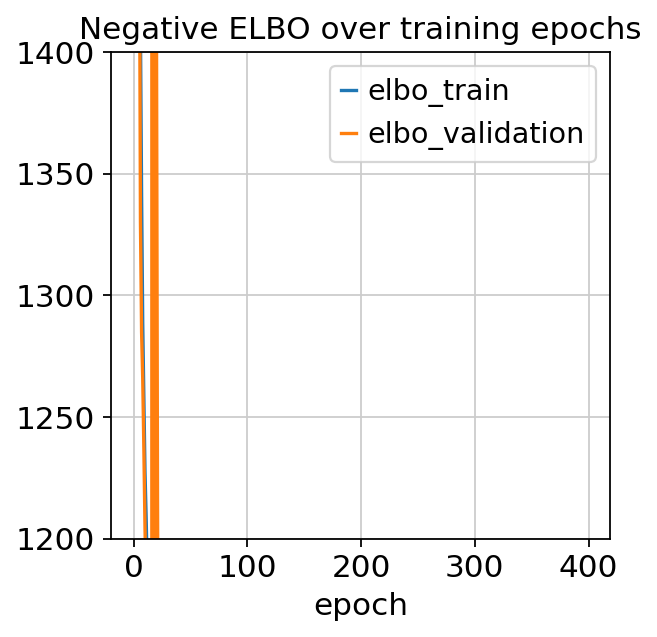

In [ ]:
import anndata as ad
import matplotlib.pyplot as plt
import mudata as md
import muon
import scanpy as sc
import scvi
import time

t = time.time()
scvi.settings.seed = 1234

sc.set_figure_params(figsize=(4, 4))

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

from scipy.sparse import issparse

for path in ['../../datasets/Human_Lymph_Node_A1/','../../datasets/Human_Lymph_Node_D1/']:
    adata_RNA = sc.read_h5ad(path + 'adata_RNA.h5ad')
    adata_ADT = sc.read_h5ad(path + 'adata_ADT.h5ad')
    
    if issparse(adata_RNA.X):
        adata_RNA.X = adata_RNA.X.toarray()
    if  issparse(adata_ADT.X):    
        adata_ADT.X = adata_ADT.X.toarray()
        
    adata_RNA.var_names_make_unique()
    adata_ADT.var_names_make_unique()
    
    adata_RNA.obs['batch'] = 'Thymus'
    adata_RNA.layers['counts'] = adata_RNA.X.copy()
    
    mdata = md.MuData({"rna": adata_RNA, "protein": adata_ADT})
    
    
    sc.pp.highly_variable_genes(
        mdata.mod["rna"],
        n_top_genes=4000,
        flavor="seurat_v3",
        batch_key="batch",
        layer="counts",
    )
    # Place subsetted counts in a new modality
    mdata.mod["rna_subset"] = mdata.mod["rna"][
        :, mdata.mod["rna"].var["highly_variable"]
    ].copy()
    print(mdata)

    try:
        mdata.update()
    except:
        mdata.update()
        
    scvi.model.TOTALVI.setup_mudata(
        mdata,
        rna_layer="counts",
        protein_layer=None,
        batch_key="batch",
        modalities={
            "rna_layer": "rna_subset",
            "protein_layer": "protein",
            "batch_key": "rna_subset",
        }
    )
    vae = scvi.model.TOTALVI(mdata,n_latent=64)
    vae.to_device("cuda:2")
    vae.train()
    
    fig, ax = plt.subplots(1, 1)
    vae.history["elbo_train"].plot(ax=ax, label="train")
    vae.history["elbo_validation"].plot(ax=ax, label="validation")
    ax.set(title="Negative ELBO over training epochs", ylim=(1200, 1400))
    ax.legend()
    
    rna = mdata.mod["rna_subset"]
    protein = mdata.mod["protein"]
    # arbitrarily store latent in rna modality
    rna.obsm["X_totalVI"] = vae.get_latent_representation()

    result_path=path.replace("datasets","results")
    rna.write_h5ad(result_path+'/adata_totalVI.h5ad')